In [1]:
import spotipy
import spotipy.util as util
from api_config_z import Client_ID, Client_Secret
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import seaborn as sns
%matplotlib inline
style.use('ggplot')

In [2]:
# authorizations for spotify access
token = spotipy.oauth2.SpotifyClientCredentials(client_id=Client_ID, client_secret=Client_Secret)
cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

C:\Users\zuzan\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
# Function for downloading playlist data and audio features for one playlist 
# see more information in: https://towardsdatascience.com/how-to-create-large-music-datasets-using-spotipy-40e7242cc6a6
def analyze_playlist(creator, playlist_id):
    
    # Create empty dataframe
    playlist_features_list = ["artist","album","track_name","track_id","popularity","acousticness","danceability",
                              "energy","key","loudness","mode","speechiness","instrumentalness","liveness","valence",
                              "tempo","duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Loop through every track in the playlist, extract features and append the features to the playlist df
    
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        # Create empty dict
        playlist_features = {}
        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        playlist_features["popularity"] = track["track"]["popularity"]
        
        # Get audio features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[5:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

In [4]:
# Function to download multiple playlist in one dataframe 
# see more in: https://towardsdatascience.com/how-to-create-large-music-datasets-using-spotipy-40e7242cc6a6
def analyze_playlist_dict(playlist_dict):
    
    # Loop through every playlist in the dict and analyze it
    for i, (key, val) in enumerate(playlist_dict.items()):
        playlist_df = analyze_playlist(*val)
        # Add a playlist column so that we can see which playlist a track belongs too
        playlist_df["playlist"] = key
        # Create or concat df
        if i == 0:
            playlist_dict_df = playlist_df
        else:
            playlist_dict_df = pd.concat([playlist_dict_df, playlist_df], ignore_index = True)
            
    return playlist_dict_df

### Playlist vs Mood

I was interested how the playlists I am listening to differ based on my mood. I have 3 favorite playlists that I each listen to in different situations:
 - Confidence Boost
 - Sunday Morning - Paris Cafe
 - Slow Down and Breath Babe
First I downloaded the data using spotipy based on the playlists IDs

In [5]:
# Create a dictionary of playlists identificators needed 
playlist_id = ["37i9dQZF1DX4fpCWaHOned", "3ssqtyMsmRFCcOoAzvphwu", "4BlcsJJS5AjcKPRRgeWZz8"]
playlist_name = ["confidence_boost", "slow_down_and_breath", "sunday_morning_paris_cafe"]
username = []
for playlist in playlist_id:
    username.append(sp.playlist(playlist)["owner"]["id"])
username
my_playlist_dict = {playlist_name[i]: (username[i], playlist_id[i]) for i in range(len(playlist_name))}

In [6]:
# Download playlists data and audio features for each track
zuzana_playlist_df = analyze_playlist_dict(my_playlist_dict)
zuzana_playlist_df["playlist"].value_counts()

sunday_morning_paris_cafe    100
confidence_boost              70
slow_down_and_breath          14
Name: playlist, dtype: int64

In [7]:
zuzana_playlist_df.head(3)

,artist,album,track_name,track_id,popularity,acousticness,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,playlist
0,Anne-Marie,To Be Young (feat. Doja Cat),To Be Young (feat. Doja Cat),4YAg8h8WliHZlW5wuv8Jpk,74,0.317,0.512,0.595,8,-5.131,1,0.0868,0.000013,0.113,0.253,156.044,204447,4,confidence_boost
1,R3HAB,Good Example (with Andy Grammer),Good Example (with Andy Grammer),5SspaMrPfWyRCS0GpjIxa6,72,0.427,0.456,0.496,1,-6.986,1,0.0743,0.000000,0.134,0.450,90.552,149053,4,confidence_boost
2,Bebe Rexha,"You Can't Stop The Girl (From Disney's ""Malefi...","You Can't Stop The Girl (From Disney's ""Malefi...",1i3z3GR1JtLswOSJNO0BQw,73,0.706,0.394,0.718,7,-6.336,1,0.0607,0.000000,0.116,0.247,151.912,158258,4,confidence_boost


In [8]:
# Data cleaning - there are no duplicates (as expected) and based on the data exploration we need to change some
# of the data types - e.g. popularity is downloaded as string, it should be numerical.
len(zuzana_playlist_df['track_id'].unique())
zuzana_playlist_df.dtypes

artist               object
album                object
track_name           object
track_id             object
popularity           object
acousticness        float64
danceability        float64
energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms          object
time_signature       object
playlist             object
dtype: object

In [9]:
zuzana_playlist_df["popularity"] = zuzana_playlist_df.popularity.astype(float)
#zuzana_playlist_df["duration_ms"] = zuzana_playlist_df.duration_ms.astype(float)
zuzana_playlist_df.dtypes

artist               object
album                object
track_name           object
track_id             object
popularity          float64
acousticness        float64
danceability        float64
energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms          object
time_signature       object
playlist             object
dtype: object

In [10]:
# Normalising the loudness to scale 0 to 1 
#resource: https://towardsdatascience.com/predicting-my-mood-using-my-spotify-data-2e898add122a
from sklearn import preprocessing
loudness = zuzana_playlist_df[['loudness']].values
min_max_scaler = preprocessing.MinMaxScaler()
zuzana_playlist_df['loudness'] = min_max_scaler.fit_transform(loudness)

In [11]:
# Exploring data further
zuzana_playlist_df
zuzana_playlist_df.groupby('playlist').corr()

popularity  acousticness  \
playlist                                                               
confidence_boost          popularity          1.000000      0.038973   
                          acousticness        0.038973      1.000000   
                          danceability        0.208915     -0.151881   
                          energy             -0.203224     -0.363526   
                          loudness           -0.100559     -0.243409   
                          speechiness        -0.043387     -0.060413   
                          instrumentalness   -0.147257     -0.106111   
                          liveness           -0.023692     -0.030820   
                          valence            -0.026218     -0.222293   
                          tempo              -0.369378     -0.045094   
slow_down_and_breath      popularity          1.000000      0.158751   
                          acousticness        0.158751      1.000000   
                          danceability        0.349340     -0.619502   
                          energy              0.391512     -0.575216   
                          loudness            0.261613     -0.473267   
                          speechiness        -0.236622      0.337052   
                          instrumentalness    0.237819      0.437235   
                          liveness            0.268532      0.233171   
                          valence             0.463118     -0.264860   
                          tempo               0.007318      0.053339   
sunday_morning_paris_cafe popularity          1.000000     -0.064582   
                          acousticness       -0.064582      1.000000   
                          danceability        0.061999     -0.207716   
                          energy             -0.049368     -0.466786   
                          loudness           -0.138799     -0.337872   
                          speechiness        -0.037667      0.037687   
                          instrumentalness    0.167293      0.045803   
                          liveness            0.040288     -0.116858   
                          valence            -0.036218     -0.120555   
                          tempo               0.053469     -0.086804   

                                            danceability    energy  loudness  \
playlist                                                                       
confidence_boost          popularity            0.208915 -0.203224 -0.100559   
                          acousticness         -0.151881 -0.363526 -0.243409   
                          danceability          1.000000  0.170063  0.106293   
                          energy                0.170063  1.000000  0.679768   
                          loudness              0.106293  0.679768  1.000000   
                          speechiness           0.053209  0.090701  0.013035   
                          instrumentalness      0.114219  0.217870  0.165801   
                          liveness             -0.041427  0.306492  0.299763   
                          valence               0.498279  0.387147  0.228455   
                          tempo                -0.319607  0.236605  0.168460   
slow_down_and_breath      popularity            0.349340  0.391512  0.261613   
                          acousticness         -0.619502 -0.575216 -0.473267   
                          danceability          1.000000  0.851965  0.731193   
                          energy                0.851965  1.000000  0.883579   
                          loudness              0.731193  0.883579  1.000000   
                          speechiness          -0.344795 -0.190616 -0.032778   
                          instrumentalness     -0.226994 -0.344245 -0.429247   
                          liveness             -0.244189 -0.123192  0.093110   
                          valence               0.833520  0.781422  0.622428   
                          tempo                 0.112579  0

In [12]:
# We will be comparing means of audio features for each playlist. 
# create new df for means (we used transpose function for better readibility and further work with data) 
compare_playlists = zuzana_playlist_df.groupby("playlist").mean().T
compare_playlists

playlist,confidence_boost,slow_down_and_breath,sunday_morning_paris_cafe
popularity,72.557143,22.928571,22.470000
acousticness,0.148654,0.848400,0.741797
danceability,0.661071,0.310400,0.623480
energy,0.706957,0.155116,0.324724
loudness,0.881218,0.336247,0.609479
speechiness,0.103051,0.042221,0.045753
instrumentalness,0.000781,0.611132,0.072454
liveness,0.184004,0.155193,0.144732
valence,0.495240,0.156779,0.477532
tempo,120.773714,108.406714,115.299590


In [13]:
# drop rows of means that we will be not comparing and where values are in different value scale (popularity, tempo
# and speechiness)
features_df = compare_playlists.drop(['popularity', 'tempo','speechiness'])
features_df

playlist,confidence_boost,slow_down_and_breath,sunday_morning_paris_cafe
acousticness,0.148654,0.848400,0.741797
danceability,0.661071,0.310400,0.623480
energy,0.706957,0.155116,0.324724
loudness,0.881218,0.336247,0.609479
instrumentalness,0.000781,0.611132,0.072454
liveness,0.184004,0.155193,0.144732
valence,0.495240,0.156779,0.477532


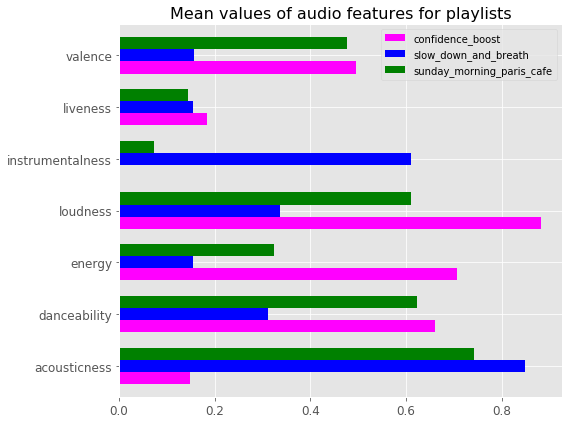

In [14]:
# Create a horizontal bar plot for comparing means of selected audio features between the playlists
features_df.plot(kind="barh", figsize=(8,6), color = ['magenta','blue', 'green'], grid=True, width=0.7, fontsize=12)
plt.title('Mean values of audio features for playlists', fontsize = 16)
plt.legend(fontsize = 10)
plt.tight_layout()
plt.savefig("MusicMoodImages/Means_playlists_bar.png")
plt.show()

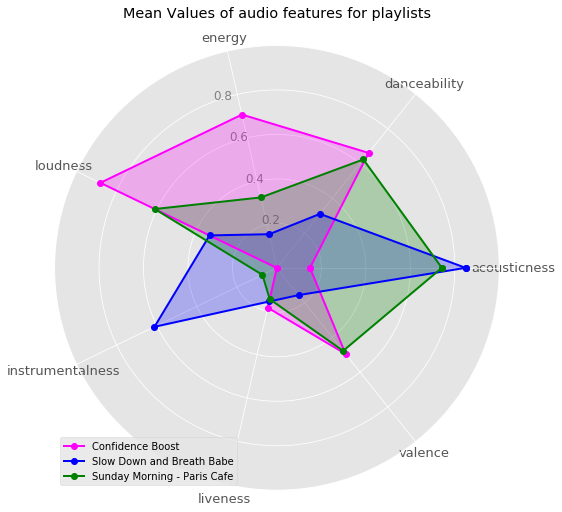

In [15]:
# For better visualisation create a radar/spider plot showing the differences between playlists
labels = list(features_df.index)
stats1 = features_df['confidence_boost']
stats2 = list(features_df['slow_down_and_breath'])
stats3 = list(features_df['sunday_morning_paris_cafe'])

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

#close the plot
stats1 = np.concatenate((stats1, [stats1[0]]))
stats2 = np.concatenate((stats2, [stats2[0]]))
stats3 = np.concatenate((stats3, [stats3[0]]))
angles = np.concatenate((angles, [angles[0]]))

# Size of the figure
fig = plt.figure(figsize =(18,18))

ax = fig.add_subplot(221, polar = True)
ax.plot(angles, stats1, 'o-', linewidth = 2, label = "Confidence Boost", color ='magenta')
ax.fill(angles, stats1, alpha = 0.25, facecolor = 'magenta')
ax.set_thetagrids(angles *180/np.pi, labels, fontsize = 13)

ax.set_rlabel_position(111)
plt.yticks([0.2, 0.4, 0.6, 0.8 ], ["0.2", "0.4", "0.6", "0.8"], color ="grey", size=12)
plt.ylim(0,1)

ax.plot(angles, stats2, 'o-', linewidth = 2, label = "Slow Down and Breath Babe", color ='blue')
ax.fill(angles, stats2, alpha = 0.25, facecolor = 'blue')

ax.plot(angles, stats3, 'o-', linewidth = 2, label = "Sunday Morning - Paris Cafe", color ='green')
ax.fill(angles, stats3, alpha = 0.25, facecolor = 'green')

ax.set_title('Mean Values of audio features for playlists')
ax.grid(True)

plt.legend(loc='lower left')

plt.savefig("MusicMoodImages/Means_playlists_radar.png")
plt.show()

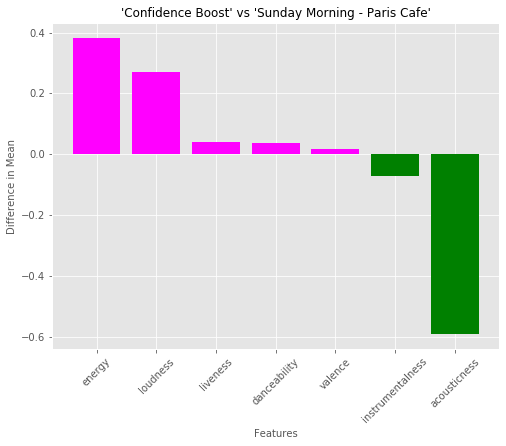

In [28]:
# Create a bar plot for comparison of differences between 'Confidence Boost' and 'Sunday Morning - Paris Cafe' playlist
# Calculate the differences and sort values in descending order
diff1 = features_df.confidence_boost - features_df.sunday_morning_paris_cafe
diff1 = diff1.sort_values(ascending=False)

# The colors for each bar needs to be assigned manually based on which playlist's value is higher:
colors = []
for i in diff1:
    if i > 0:
        colors.append('magenta')
    else:
        colors.append('green')

#Create a bar plot with assigning the colors as defined in the step above
x = np.arange(len(diff1))
y = diff1
plt.figure(figsize =(8,6))
plt.bar(x,y, color = colors)
plt.xticks(x, diff1.index, rotation=45)
plt.ylabel('Difference in Mean', fontsize = 10)
plt.xlabel('Features', fontsize = 10)
plt.title("'Confidence Boost' vs 'Sunday Morning - Paris Cafe'", fontsize = 12)
plt.savefig("MusicMoodImages/Confidence_Sunday_meansdiff.png")
plt.show()

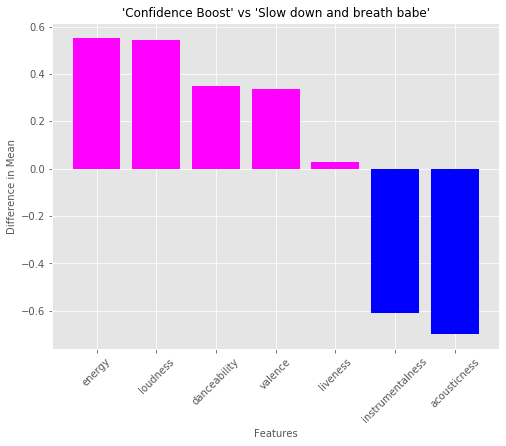

In [42]:
# Create a bar plot for comparison of differences between 'Confidence Boost' and 'Slow down and breath babe'
# Calculate the differences and sort values in descending order
diff2 = features_df.confidence_boost - features_df.slow_down_and_breath
diff2 = diff2.sort_values(ascending=False)

# The colors for each bar needs to be assigned manually based on which playlist's value is higher:
colors = []
for i in diff2:
    if i > 0:
        colors.append('magenta')
    else:
        colors.append('blue')

#Create a bar plot with assigning the colors as defined in the step above
x = np.arange(len(diff2))
y = diff2
plt.figure(figsize =(8,6))
plt.bar(x,y, color = colors)
plt.xticks(x, diff2.index, rotation=45)
plt.ylabel('Difference in Mean', fontsize = 10)
plt.xlabel('Features', fontsize = 10)
plt.title("'Confidence Boost' vs 'Slow down and breath babe'", fontsize = 12)
plt.savefig("MusicMoodImages/Confidence_Breath_meansdiff.png")
plt.show()

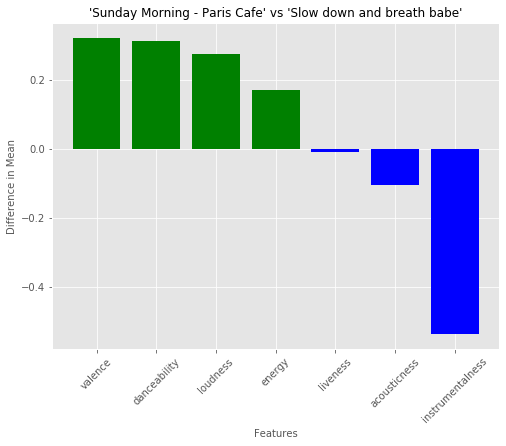

In [43]:
# Create a bar plot for comparison of differences between 'Sunday Morning - Paris Cafe' and 'Slow down and breath babe'
# Calculate the differences and sort values in descending order
diff3 = features_df.sunday_morning_paris_cafe - features_df.slow_down_and_breath
diff3 = diff3.sort_values(ascending=False)

# The colors for each bar needs to be assigned manually based on which playlist's value is higher:
colors = []
for i in diff3:
    if i > 0:
        colors.append('green')
    else:
        colors.append('blue')

#Create a bar plot with assigning the colors as defined in the step above
x = np.arange(len(diff3))
y = diff3
plt.figure(figsize =(8,6))
plt.bar(x,y, color = colors)
plt.xticks(x, diff3.index, rotation=45)
plt.ylabel('Difference in Mean', fontsize = 10)
plt.xlabel('Features', fontsize = 10)
plt.title("'Sunday Morning - Paris Cafe' vs 'Slow down and breath babe'", fontsize = 12)
plt.savefig("MusicMoodImages/Sunday_Breath_meansdiff.png")
plt.show()

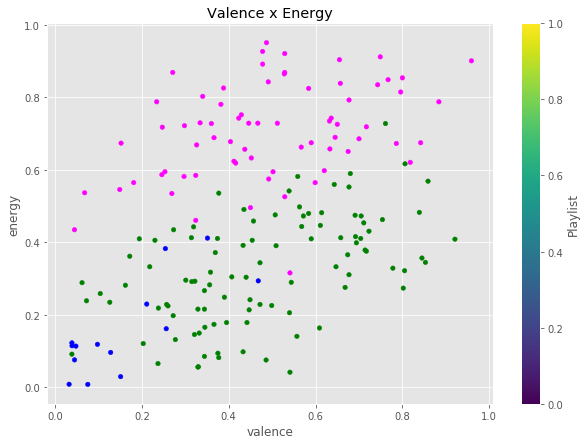

In [44]:
# Correlation Between Variables:  Valence x Energy

# assign to playlist df a column that will be used to assign the different color in the scatter plot
color = []
for i in zuzana_playlist_df['playlist']:
    if i == "confidence_boost":
        color.append('magenta')
    if i == "sunday_morning_paris_cafe":
        color.append('green')
    if i == "slow_down_and_breath":
        color.append('blue')
zuzana_playlist_df['Playlist'] = color

# Create scatter plot for Valence vs Energy 
fig, ax = plt.subplots()
zuzana_playlist_df.plot(kind = 'scatter', x= 'valence', y= 'energy', c = 'Playlist', ax=ax, title ="Valence x Energy", 
                        figsize=(10,7))
plt.savefig("MusicMoodImages/Valence_Energy_corr.png")
plt.show()

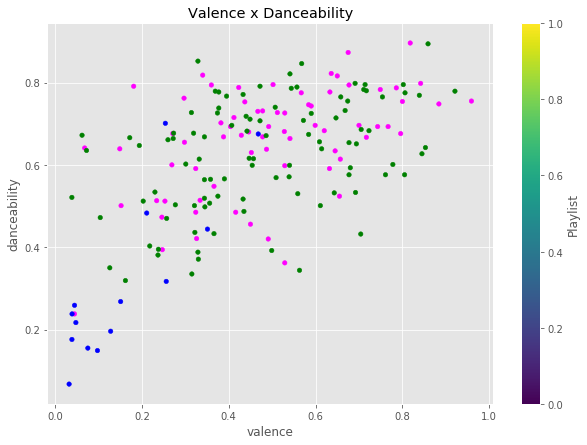

In [45]:
# Create scatter plot for Valence vs Dancebility
fig, ax = plt.subplots()
zuzana_playlist_df.plot(kind = 'scatter', x= 'valence', y= 'danceability', c = 'Playlist', ax=ax, 
                        title ="Valence x Danceability", figsize=(10,7))
plt.savefig("MusicMoodImages/Valence_Danceability_corr.png")
plt.show()

In [34]:
#Diversity of the lists - calculate the mean of standard deviations to be able to compare
mean_std=((zuzana_playlist_df.groupby('playlist')).std().T).drop(['popularity', 'tempo']).mean()
mean_std

playlist
confidence_boost             0.120834
slow_down_and_breath         0.184900
sunday_morning_paris_cafe    0.146820
dtype: float64

In [35]:
# Independent T-Tests for valence and danceability for Confidence Boost and Sunday Morning -Paris Cafe playlists
import scipy.stats as stats
confidence_danceability = zuzana_playlist_df.danceability[zuzana_playlist_df['playlist'] == "confidence_boost"]
sunday_danceability = zuzana_playlist_df.danceability[zuzana_playlist_df['playlist'] == "sunday_morning_paris_cafe"]
danceability_ttest = stats.ttest_ind(confidence_danceability, sunday_danceability, equal_var=False)
danceability_ttest

confidence_valence = zuzana_playlist_df.valence[zuzana_playlist_df['playlist'] == "confidence_boost"]
sunday_valence = zuzana_playlist_df.valence[zuzana_playlist_df['playlist'] == "sunday_morning_paris_cafe"]
valence_ttest = stats.ttest_ind(confidence_valence, sunday_valence, equal_var=False)
valence_ttest

print(f"Results of Independent T-Tests for comparison of 'Confidence Boost' and 'Sunday Morning - Paris Cafe' playlist")
print(f"for danceability:")
print(danceability_ttest)
print("------")
print(f"for valence:")
print(valence_ttest)   


Results of Independent T-Tests for comparison of 'Confidence Boost' and 'Sunday Morning - Paris Cafe' playlist
for danceability:
Ttest_indResult(statistic=1.8222235327277319, pvalue=0.07037992893382619)
------
for valence:
Ttest_indResult(statistic=0.5565110396042272, pvalue=0.578685545833565)


In [36]:
# visualisations for T-Tests above:
def gendata(loc1=0, loc2=0):

    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population1)), population1, label="population1")
    plt.scatter(range(len(population2)), population2, label="population2")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(population1, 10, density=True, alpha=0.7, label="population1")
    plt.hist(population2, 10, density=True, alpha=0.7, label="population2")
    plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    return population1, population2

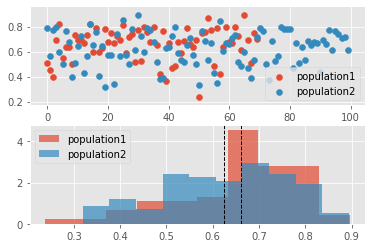

In [37]:
population1=confidence_danceability
population2=sunday_danceability
population1, population2 = gendata()

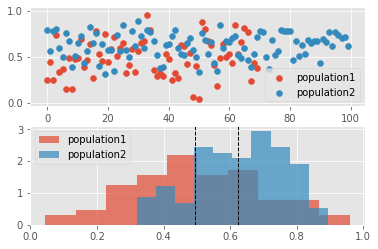

In [38]:
population1=confidence_valence
population2=sunday_valence =gendata()